In [109]:
from sympy import symbols
from sympy.plotting import plot
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pandas as pd

from PIL import Image
import tensorflow as tf
import os, warnings

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import tensorflow_hub as hub

## Importing the dataset

Firstly, the data should be imported into the pandas dataframes for easy manipulation. 

In [110]:
batch_size = 16
data_dir = "/Users/anna-alexandradanchenko/Documents/University/IdentMathFunc/Math-Functions-Identification/data"
img_height = 224
img_width = 224


# Some images are png with transparency. We need to set the white background for them so they won't appear black for the model. 
for subdir, dirs, files in os.walk(data_dir): # Iterate throught all the levels of the directories 
    for file in files:
        if file.endswith('.png'):
            img = Image.open(os.path.join(subdir, file))
            if img.mode == "RGBA":                     # Choose only images with transparency
                white_background_image = Image.new("RGBA", img.size, "WHITE") # Create a white rgba background
                white_background_image.paste(img, (0, 0), img) # Paste original png image on top of the white background
                final_img = white_background_image.convert("RGB")

                final_img.save((os.path.join(subdir, file))) # Save the image with the same filename


# for filename in os.listdir(data_dir):
#     img = Image.open(data_dir + "/" + filename)

In [111]:

df_train_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="training",

    labels='inferred',
    label_mode="categorical",
        
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=True
)

df_valid_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="validation",

    labels='inferred',
    label_mode="categorical",
    
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=False
)


Found 203 files belonging to 2 classes.
Using 163 files for training.


Found 203 files belonging to 2 classes.
Using 40 files for validation.


In [112]:
class_names = df_train_.class_names
print(class_names)

['linear', 'quadratic']


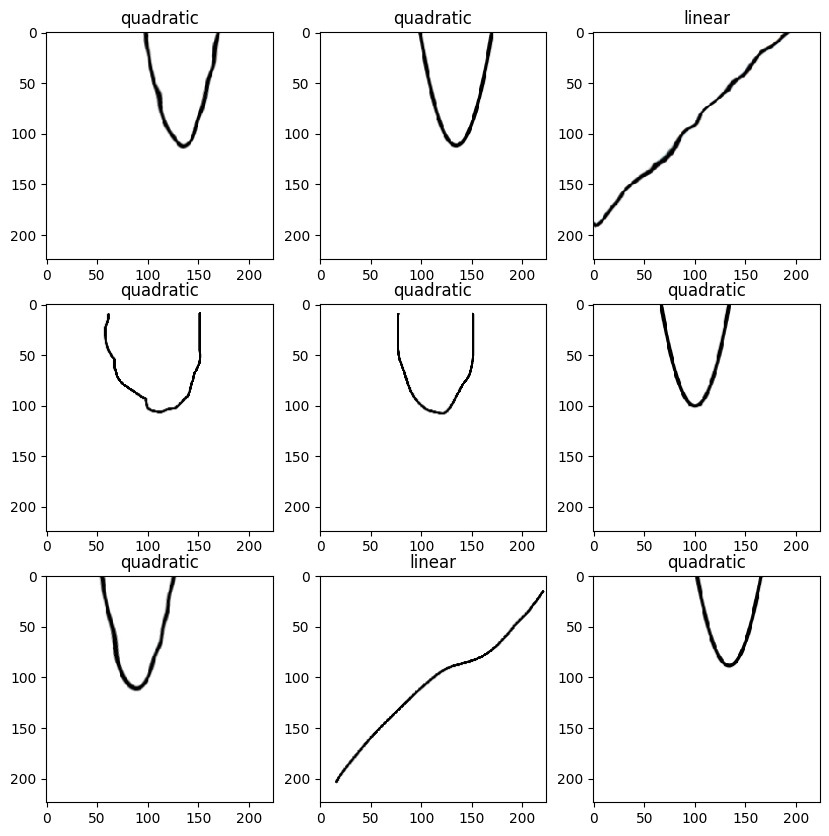

In [113]:
plt.figure(figsize=(10, 10))

for images, labels in df_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = np.argmax(labels[i].numpy()) # Returns the indices of the maximum values.
    plt.title(class_names[label_index])



## Dataset Optimization

In [114]:
AUTOTUNE = tf.data.AUTOTUNE

df_train = (
    df_train_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
df_valid = (
    df_valid_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Model Definition

In [115]:

model = tf.keras.Sequential([
    layers.Resizing(224, 224, interpolation='nearest'),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    hub.KerasLayer(
        "https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/feature-vector/versions/1",
        trainable=False
        ),  
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [116]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [117]:
history = model.fit(
    df_train,
    validation_data=df_valid,
    epochs=5
    )

Epoch 1/5


11/11 [==============================] - 10s 685ms/step - loss: 0.6234 - binary_accuracy: 0.8344 - val_loss: 0.4802 - val_binary_accuracy: 1.0000
Epoch 2/5
11/11 [==============================] - 7s 604ms/step - loss: 0.4477 - binary_accuracy: 0.9939 - val_loss: 0.3199 - val_binary_accuracy: 1.0000
Epoch 3/5
11/11 [==============================] - 8s 779ms/step - loss: 0.3219 - binary_accuracy: 1.0000 - val_loss: 0.2083 - val_binary_accuracy: 1.0000
Epoch 4/5
11/11 [==============================] - 6s 580ms/step - loss: 0.2339 - binary_accuracy: 1.0000 - val_loss: 0.1375 - val_binary_accuracy: 1.0000
Epoch 5/5
11/11 [==============================] - 8s 735ms/step - loss: 0.1707 - binary_accuracy: 1.0000 - val_loss: 0.0972 - val_binary_accuracy: 1.0000


<Axes: >

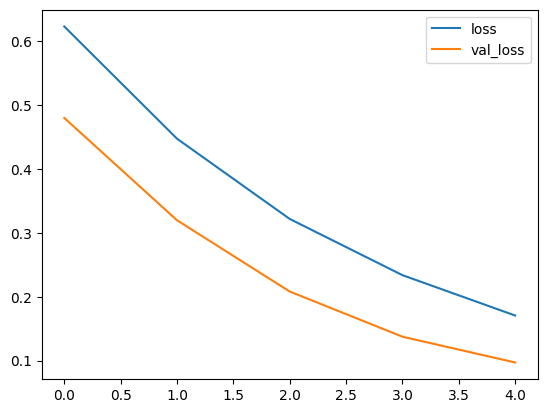

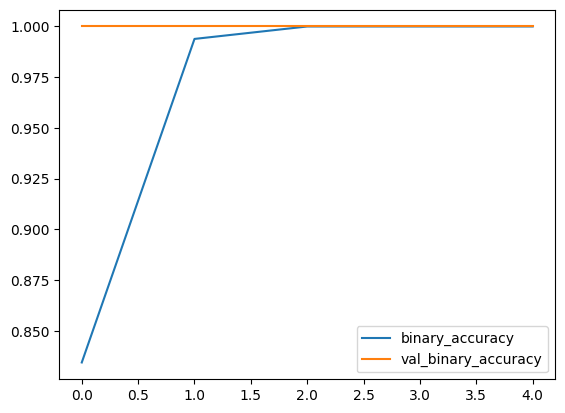

In [118]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

## Save the Model

In [119]:
model.save("model.keras", save_format="tf")

Test prediction of one image

In [122]:
model = load_model("model.keras", custom_objects={'KerasLayer':hub.KerasLayer})
img = Image.open("/Users/anna-alexandradanchenko/Documents/University/IdentMathFunc/Math-Functions-Identification/data/quadratic/function_2.0_0.0.png").resize((224, 224))
img = np.array(img)
prediction = model.predict(img[None,:,:])
pred_class = np.argmax(prediction)
print(class_names[pred_class])

1/1 [==============================] - 0s 432ms/step
quadratic
